# 00 Project Overview


This project focuses on developing, testing, and optimizing a momentum-based cryptocurrency trading strategy. The core idea is to rank a portfolio of cryptocurrencies based on key descriptive statistics and technical indicators derived from historical price and volume data. By identifying cryptocurrencies with the strongest positive momentum and those showing signs of weakness, the strategy generates buy and sell signals, respectively. The strategy is rigorously tested through backtesting, enabling the evaluation of its performance in terms of returns, volatility, and risk-adjusted metrics.

The portfolio under consideration includes a diverse range of prominent cryptocurrencies: BTC, ETH, XRP, ADA, DOGE, SOL, DOT, MATIC, and LTC, all paired against USDT. These cryptocurrencies were chosen for their significant market capitalization, liquidity, and historical trading volumes, which make them suitable candidates for a robust strategy evaluation.

In [52]:
pip install ccxt

In [53]:
pip install pandas_ta

In [54]:
import pandas as pd
import ccxt
import pandas_ta as ta

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# 01 Data


The Fetch_crypto_data_FCE function uses the ccxt library to fetch OHLCV data for specified cryptocurrencies from Kraken, organizes it into pandas DataFrames indexed by timestamp, and stores them in a dictionary. Errors are handled and reported.

In [55]:
def Fetch_crypto_data_FCE(symbols, timeframe, limit):

    # Initialize Binance exchange Kraken
    exchange = ccxt.kraken()

    # Dictionary to store dataframes
    data_frames = {}

    for symbol in symbols:
        print(f"Fetching data for {symbol}...")
        try:

            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=start_time)

            # Convert to pandas DataFrame
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            # Store in the dictionary
            data_frames[symbol.replace('/', '_')] = df

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    return data_frames

Download data

In [56]:
symbols_download = ['BTC/USDT', 'ETH/USDT', 'XRP/USDT', 'ADA/USDT',
           'DOGE/USDT', 'SOL/USDT', 'DOT/USDT', 'MATIC/USDT', 'LTC/USDT']

symbols = ['BTC_USDT', 'ETH_USDT', 'XRP_USDT', 'ADA_USDT',
           'DOGE_USDT', 'SOL_USDT', 'DOT_USDT', 'MATIC_USDT', 'LTC_USDT']


timeframe = '1w'
limit = 5000
start_time = int(pd.Timestamp('2023-01-01').timestamp() * 1000)

# Fetch data
crypto_data = Fetch_crypto_data_FCE(symbols_download, timeframe, start_time)

Fetching data for BTC/USDT...
Fetching data for ETH/USDT...
Fetching data for XRP/USDT...
Fetching data for ADA/USDT...
Fetching data for DOGE/USDT...
Fetching data for SOL/USDT...
Fetching data for DOT/USDT...
Fetching data for MATIC/USDT...
Fetching data for LTC/USDT...


In [57]:
crypto_data['BTC_USDT'].head()

,open,high,low,close,volume
timestamp,,,,,
2023-01-05,16861.0,17980.7,16697.0,17945.2,1907.579954
2023-01-12,17957.4,21655.6,17912.5,20678.5,3345.332158
2023-01-19,20673.4,23791.9,20673.4,23060.8,2432.729123
2023-01-26,23077.6,23940.9,22511.0,23716.8,2009.703620
2023-02-02,23724.5,24239.5,22632.8,22934.6,1622.925020


Logarithmic returns assume continuous compounding, making them additive over time. They enable direct comparisons across assets and align with the log-normal distribution of asset prices, simplifying risk and volatility assessments.

In [58]:
for coin in symbols:

  crypto_data[coin]["log_returns"] = np.log(crypto_data[coin]["close"] / crypto_data[coin]["close"].shift(1))
  crypto_data[coin]["log_volume_returns"] = np.log(crypto_data[coin]["volume"] / crypto_data[coin]["volume"].shift(1))

In [59]:
crypto_data['BTC_USDT']

,open,high,low,close,volume,log_returns,log_volume_returns
timestamp,,,,,,,
2023-01-05,16861.0,17980.7,16697.0,17945.2,1907.579954,NaN,NaN
2023-01-12,17957.4,21655.6,17912.5,20678.5,3345.332158,0.141772,0.561731
2023-01-19,20673.4,23791.9,20673.4,23060.8,2432.729123,0.109040,-0.318552
2023-01-26,23077.6,23940.9,22511.0,23716.8,2009.703620,0.028049,-0.191026
2023-02-02,23724.5,24239.5,22632.8,22934.6,1622.925020,-0.033537,-0.213757
...,...,...,...,...,...,...,...
2024-12-26,99410.0,99892.1,91500.0,94587.6,1119.059483,-0.049562,-0.586803
2025-01-02,94592.7,102611.0,92573.2,95065.4,1362.346069,0.005039,0.196720
2025-01-09,95055.5,100678.7,89250.0,100429.4,1363.142447,0.054890,0.000584


#02 Strategies

These indicators can be used to rank the coins based on specific trading strategies or criteria. For example:

**Price Momentum**
Coins can be ranked based on indicators like the Exponential Moving Average (EMA) of log returns, RSI, or Stochastic Oscillator, which capture the strength and direction of price movements. A coin with a higher EMA or RSI indicating bullish trends might rank higher.

**Volatility and Risk**
Indicators like Average True Range (ATR) and Keltner Channels can rank coins based on their volatility. A coin with lower ATR could be considered less risky and may be ranked higher for more conservative strategies.

**Liquidity and Volume**
The On-Balance Volume (OBV), Williams %R, and Chaikin Money Flow (CMF) can capture changes in market sentiment and liquidity. Coins with a higher OBV or CMF can be ranked higher for indicating stronger buying pressure.

**Trend Strength**
The Average Directional Index (ADX) can be used to rank coins based on the strength of their trend. Higher ADX values indicate stronger trends, so coins with a higher ADX could be ranked higher for trend-following strategies.

These indicators are combined to create ranking system that could be adjusted depending on the desired strategy (e.g., momentum, volatility, trend-following, etc.). The code provides a rich dataset for ranking coins based on their technical indicators and aligning them with a trading strategy's goals.

In [60]:
strategies = crypto_data.copy()

# For each cryptocurrency symbol
for coin in symbols:
    # EMA of log returns
    strategies[coin]["EMA_5_log_returns"] = ta.ema(crypto_data[coin]["log_returns"], length=5)
    strategies[coin]["EMA_10_log_returns"] = ta.ema(crypto_data[coin]["log_returns"], length=10)
    strategies[coin]["EMA_14_log_returns"] = ta.ema(crypto_data[coin]["log_returns"], length=14)

    # EMA of log volume returns
    strategies[coin]["EMA_5_log_volume_returns"] = ta.ema(crypto_data[coin]["log_volume_returns"], length=5)
    strategies[coin]["EMA_10_log_volume_returns"] = ta.ema(crypto_data[coin]["log_volume_returns"], length=10)
    strategies[coin]["EMA_14_log_volume_returns"] = ta.ema(crypto_data[coin]["log_volume_returns"], length=14)

    # RSI (Relative Strength Index) - Measures overbought/oversold conditions
    strategies[coin]["RSI_14"] = ta.rsi(crypto_data[coin]["close"], length=14)
    strategies[coin]["RSI_7"] = ta.rsi(crypto_data[coin]["close"], length=7)

    # ATR (Average True Range) - Measures market volatility
    strategies[coin]["ATR_14"] = ta.atr(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=14)
    strategies[coin]["ATR_7"] = ta.atr(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=7)

    # Stochastic Oscillator - Momentum indicator
    stoch = ta.stoch(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], k=14, d=3)
    strategies[coin]["Stoch_K1"] = stoch["STOCHk_14_3_3"]
    strategies[coin]["Stoch_D1"] = stoch["STOCHk_14_3_3"]

    stoch2 = ta.stoch(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], k=14, d=3)
    strategies[coin]["Stoch_K2"] = stoch2["STOCHk_14_3_3"]
    strategies[coin]["Stoch_D2"] = stoch2["STOCHk_14_3_3"]

    # ADX (Average Directional Index) - Measures trend strength
    adx = ta.adx(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=14)
    strategies[coin]["ADX_14"] = adx['ADX_14']

    adx = ta.adx(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=7)
    strategies[coin]["ADX_7"] = adx['ADX_7']

    # CCI (Commodity Channel Index) - Identifies cyclical trends
    strategies[coin]["CCI_14"] = ta.cci(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=14)

    # OBV (On-Balance Volume) - Uses volume flow to predict changes in stock price
    strategies[coin]["OBV"] = ta.obv(crypto_data[coin]["close"], crypto_data[coin]["volume"])

    # Williams %R - Measures overbought/oversold conditions (scale: -100 to 0)
    strategies[coin]["Williams_%R"] = ta.willr(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=14)

    # Chaikin Money Flow (CMF) - Measures Money Flow Volume
    strategies[coin]["CMF_14"] = ta.cmf(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], crypto_data[coin]["volume"], length=14)

    # Donchian Channels - Measures high/low prices over a period (default 20 periods)
    dc = ta.donchian(crypto_data[coin]["close"], low=crypto_data[coin]["low"], length=14)
    strategies[coin]["DC_upper"] = dc["DCU_20_20"]/crypto_data[coin]["close"]
    strategies[coin]["DC_lower"] = dc["DCL_20_20"]/crypto_data[coin]["close"]

    # Keltner Channel - Volatility-based envelope
    kc = ta.kc(crypto_data[coin]["high"], crypto_data[coin]["low"], crypto_data[coin]["close"], length=14, multiplier=1.5)
    strategies[coin]["KC_upper"] = kc["KCLe_14_2"]/crypto_data[coin]["close"]
    strategies[coin]["KC_middle"] = kc["KCBe_14_2"]/crypto_data[coin]["close"]
    strategies[coin]["KC_lower"] = kc["KCUe_14_2"]/crypto_data[coin]["close"]

    strategies[coin] = strategies[coin].drop(index=strategies[coin].index[:25])

In [61]:
try:
  for coin in symbols:
    strategies[coin] = strategies[coin].drop(columns=['open', 'high', 'low', 'close',  'volume'])
except:
    pass

#03 Backtester

The Backtester_FCE function simulates a cryptocurrency trading strategy by ranking coins based on a chosen strategy and weighting them accordingly.

**01 Signal Extraction**

It stores the strategy column values for each coin in a signals DataFrame.

**02 Ranking**

The coins are ranked per time point, with higher values receiving better ranks.

**03 Normalizing Ranks**

The ranks are normalized to a scale between 0 and 1, ensuring higher-ranked coins get more weight.

**04 Portfolio Construction**

The portfolio is built by multiplying log returns (shifted by one day) with normalized weights, giving more weight to higher-ranked coins.
Portfolio Calculation: It calculates the daily and cumulative returns of the portfolio.

In [62]:
def Normalize_ranks(df):
    num_columns = df.shape[1]  # Number of columns in the DataFrame

    return (1 - (df - 1) * (2 / (num_columns - 1)))


def Backtester_FCE(data, strategy_column):

  signals = pd.DataFrame()
  ranks = pd.DataFrame()
  weights_by_rank = pd.DataFrame()
  portfolio = pd.DataFrame()

  for coin in symbols:
    signals[coin] = data[coin][strategy_column]

  ranks = signals.rank(axis=1, ascending=False)
  weights_by_rank = Normalize_ranks(ranks)

  for coin in symbols:
    portfolio[coin] = data[coin]["log_returns"].shift(-1) * weights_by_rank[coin]

  portfolio["portfolio_daily"] = portfolio.sum(axis=1)
  portfolio["portfolio_sum"] = portfolio["portfolio_daily"].cumsum()

  return portfolio["portfolio_daily"], portfolio["portfolio_sum"]

Perform backtest

In [63]:
strategies_returns = pd.DataFrame()
strategies_equity = pd.DataFrame()


strategies_list = strategies['BTC_USDT'].columns.tolist()


for strategy in strategies_list:
  daily_returns, equity_curve = Backtester_FCE(strategies, strategy)

  strategies_returns[strategy] = daily_returns
  strategies_equity[strategy] = equity_curve

In [64]:
strategies_returns.tail()

,log_returns,log_volume_returns,EMA_5_log_returns,EMA_10_log_returns,EMA_14_log_returns,EMA_5_log_volume_returns,EMA_10_log_volume_returns,EMA_14_log_volume_returns,RSI_14,RSI_7,...,ADX_7,CCI_14,OBV,Williams_%R,CMF_14,DC_upper,DC_lower,KC_upper,KC_middle,KC_lower
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-26,0.127460,-0.152062,0.052082,0.088250,0.088250,-0.103722,-0.107059,-0.107059,0.108993,0.066296,...,0.078235,0.000527,0.090131,0.093459,0.127777,-0.050302,-0.082886,-0.036585,-0.066363,-0.053764
2025-01-02,0.163569,0.239550,0.269150,0.325759,0.330819,-0.144531,-0.141283,-0.140972,0.287987,0.287226,...,0.319744,0.294437,0.201604,0.234155,0.156773,-0.148386,-0.313527,-0.311966,-0.321460,-0.170189
2025-01-09,-0.158411,0.248291,0.056521,-0.108103,-0.108103,0.209385,0.234171,0.162543,0.121817,0.050189,...,-0.176923,-0.143094,-0.097928,0.050189,0.204825,-0.040495,0.071562,0.188297,0.108103,-0.050189
2025-01-16,0.079705,-0.210186,0.098814,0.069000,0.047393,-0.060532,-0.035374,-0.011060,0.093362,0.136576,...,0.081943,0.086319,-0.102700,0.093362,0.069913,-0.121621,-0.016657,0.030761,-0.069000,-0.155447
2025-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 04 Estimation & Validation Split

In order to be able to select strategies for portfolio, resturns are splited into two periods.

**Estimation period**

Best strategies are selected and portfolio is calcualted.

**Valaidation period**

Results are validate in "unbiased" way.

In [65]:
split_date = '2024-01-01'

estimation_returns = strategies_returns[strategies_returns.index < split_date]
validation_returns = strategies_returns[strategies_returns.index >= split_date]

estimation_equity = strategies_equity[strategies_equity.index < split_date]

estimation_returns.iloc[0] = 0
validation_returns.iloc[0] = 0

estimation_equity.iloc[0] = 0

Function to calcualte financial metrices.

In [66]:
def Calculate_stats_from_log_returns_FCE(log_returns_df: pd.DataFrame, risk_free_rate: float = 0.0) -> pd.DataFrame:

  stats = []

  for strategy in log_returns_df.columns:


    log_returns = log_returns_df[strategy]

    # Annual Return:
    annual_return = log_returns.mean() * 52  # Assuming H4 data

    # Cumulative Return:
    cumulative_return = log_returns_df[strategy].cumsum().iloc[-1]

    # Year Volatility:
    annual_volatility = log_returns.std() * np.sqrt(52)  # Assuming H4 data

    # Sharpe Ratio:
    risk_free_rate = 0.02  # You can adjust this value
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    # Sortino Ratio:
    downside_returns = log_returns_df[strategy][log_returns_df[strategy] < 0]
    downside_volatility = downside_returns.std() * np.sqrt(52)  # Assuming weekly data
    sortino_ratio = (annual_return - risk_free_rate) / downside_volatility


    df = log_returns_df.copy()

    # Max DrawDown

    df['cumulative_return'] = log_returns.cumsum()
    df['running_max'] = df['cumulative_return'].cummax()
    df['drawdown'] = df['running_max']- df['cumulative_return']

    # Find Max DD
    max_drawdown = df['drawdown'].max()

    # Store metrics in a dictionary
    stats.append({
        'Strategy': strategy,
        'Annual Return (%)': annual_return * 100,
        'Cumulative Return (%)': cumulative_return * 100,
        'Annual Volatility (%)': annual_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown (%)': max_drawdown * 100
    })

    stats_df = pd.DataFrame(stats)

  return stats_df

# 05 Estimation period

In [67]:
estimation_equity.iloc[0] = 0

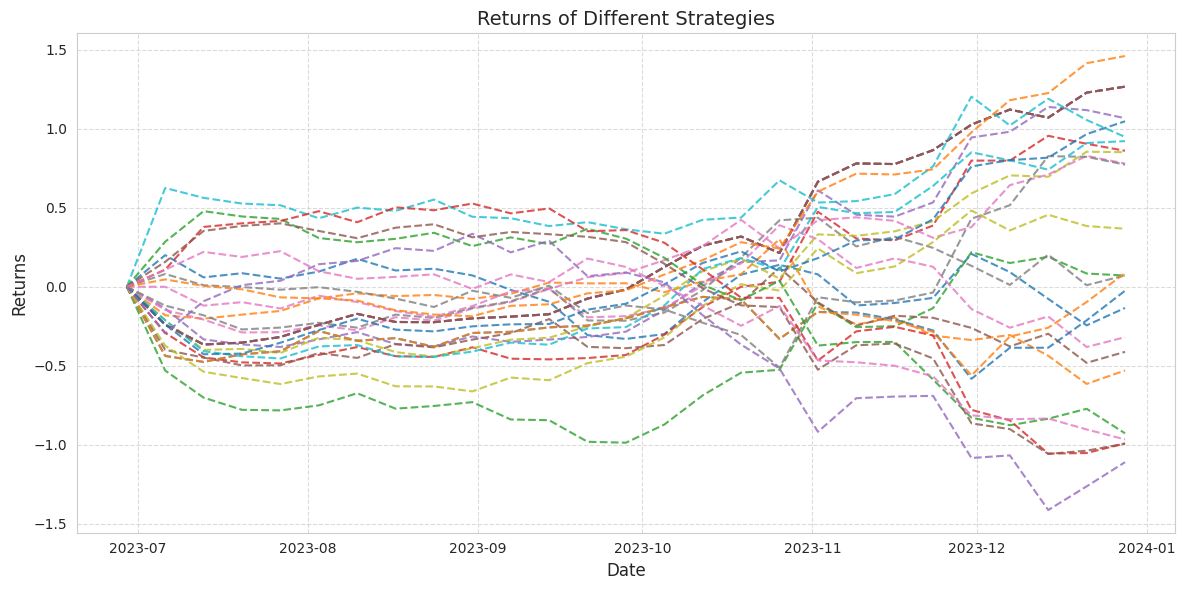

In [68]:
plt.figure(figsize=(12, 6))

for strategy in estimation_equity.columns:
    plt.plot(estimation_equity.index, estimation_equity[strategy], label=strategy, linestyle='--', alpha = 0.8)


plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)

plt.title("Returns of Different Strategies", fontsize=14)
#plt.legend(loc='best', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [69]:
stats_estimate = Calculate_stats_from_log_returns_FCE(estimation_returns).copy()


Both graph and metrices data shows significant variation, with some strategies delivering high returns at the cost of high volatility and large drawdowns, such as EMA_10_log_returns and EMA_14_log_returns. In contrast, indicators like the Stochastic Oscillator and Chaikin Money Flow offer more stable, risk-adjusted returns. However, volatility-based strategies like ATR, DC, and KC show poor returns and large drawdowns, suggesting inefficiencies in certain market conditions.

In [70]:
stats_estimate

,Strategy,Annual Return (%),Cumulative Return (%),Annual Volatility (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%)
0,log_returns,-45.245075,-23.492635,87.608698,-0.539274,-1.030139,53.032429
1,log_volume_returns,-59.132879,-30.703610,82.450276,-0.741451,-0.698817,91.589663
2,EMA_5_log_returns,17.377041,9.022695,124.163347,0.123845,0.160117,96.791995
3,EMA_10_log_returns,187.321963,97.263327,103.656704,1.787843,3.921444,37.375491
4,EMA_14_log_returns,227.207580,117.973167,99.773593,2.257186,5.066341,26.847319
5,EMA_5_log_volume_returns,-74.210799,-38.532530,91.710654,-0.830992,-0.993746,60.210756
6,EMA_10_log_volume_returns,-72.596179,-37.694170,87.608558,-0.851471,-1.301404,77.074800
7,EMA_14_log_volume_returns,-2.511186,-1.303885,87.823663,-0.051366,-0.084479,42.712255
8,RSI_14,188.689154,97.973215,71.633710,2.606163,4.200366,31.427934
9,RSI_7,204.228111,106.041519,87.163984,2.320088,5.331288,31.517407


These strategies could be inverted since they are cosnisstnetly loosing money.

In [71]:
estimation_returns_adjusted = estimation_returns.copy()

estimation_returns_adjusted['KC_lower'] = estimation_returns['DC_upper'] *-1
estimation_returns_adjusted['DC_upper'] = estimation_returns['DC_lower'] *-1

estimation_returns_adjusted['log_returns'] = estimation_returns['log_returns'] *-1

In [72]:
stats_estimate_adjusted = Calculate_stats_from_log_returns_FCE(estimation_returns_adjusted).copy()

stats_estimate_adjusted = stats_estimate_adjusted.sort_values(by='Sortino Ratio', ascending=False)

In [73]:
stats_estimate_adjusted

,Strategy,Annual Return (%),Cumulative Return (%),Annual Volatility (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%)
21,CMF_14,318.305806,165.274169,75.854632,4.169894,22.214119,23.335396
13,Stoch_D1,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
15,Stoch_D2,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
14,Stoch_K2,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
12,Stoch_K1,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
9,RSI_7,204.228111,106.041519,87.163984,2.320088,5.331288,31.517407
4,EMA_14_log_returns,227.207580,117.973167,99.773593,2.257186,5.066341,26.847319
26,KC_lower,206.785031,107.369151,94.155718,2.174961,4.801067,33.258841
20,Williams_%R,226.103366,117.399825,72.481511,3.091869,4.684428,30.050262
19,OBV,173.818048,90.251679,122.301932,1.404868,4.382565,28.936124


# 06 Portfolio of Strategies

Constructing a portfolio of strategies offers diversification, reducing risk by balancing different strategies.

A mix of strategies also helps avoid overfitting, as no single strategy can perform well in all environments. Additionally, a portfolio adapts to changing markets and allows flexible capital allocation based on strategy performance, ensuring more resilient overall performance.


The Sortino ratio is a performance metric that measures the risk-adjusted return of an investment or strategy, but unlike the Sharpe ratio, it only considers downside volatility (negative returns) rather than total volatility.

"Well" performing strategies are selected for portfolio.

In [74]:
stats_estimate_adjusted = stats_estimate_adjusted[stats_estimate_adjusted['Sortino Ratio'] >= 3]

In [75]:
stats_estimate_adjusted

,Strategy,Annual Return (%),Cumulative Return (%),Annual Volatility (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%)
21,CMF_14,318.305806,165.274169,75.854632,4.169894,22.214119,23.335396
13,Stoch_D1,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
15,Stoch_D2,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
14,Stoch_K2,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
12,Stoch_K1,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
9,RSI_7,204.228111,106.041519,87.163984,2.320088,5.331288,31.517407
4,EMA_14_log_returns,227.207580,117.973167,99.773593,2.257186,5.066341,26.847319
26,KC_lower,206.785031,107.369151,94.155718,2.174961,4.801067,33.258841
20,Williams_%R,226.103366,117.399825,72.481511,3.091869,4.684428,30.050262
19,OBV,173.818048,90.251679,122.301932,1.404868,4.382565,28.936124


In [76]:
portfolio_strategies = stats_estimate_adjusted.Strategy.to_list()


Create portfolio by suming all selected strategies and divide it by number of summed strategies. This is creating portfolio of strategies which is average strategy.

In [77]:
estimation_returns_adjusted['Portfolio'] = 0
for strategy in portfolio_strategies:
    estimation_returns_adjusted['Portfolio'] += estimation_returns_adjusted[strategy]

estimation_returns_adjusted['Portfolio'] = estimation_returns_adjusted['Portfolio'] / len(portfolio_strategies)

In [78]:
estimation_returns_adjusted = estimation_returns_adjusted[portfolio_strategies + ['Portfolio']]

In [79]:
stats_estimate_adjusted = Calculate_stats_from_log_returns_FCE(estimation_returns_adjusted)
stats_estimate_adjusted

,Strategy,Annual Return (%),Cumulative Return (%),Annual Volatility (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%)
0,CMF_14,318.305806,165.274169,75.854632,4.169894,22.214119,23.335396
1,Stoch_D1,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
2,Stoch_D2,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
3,Stoch_K2,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
4,Stoch_K1,280.687752,145.741717,78.720893,3.540201,8.339960,17.474457
5,RSI_7,204.228111,106.041519,87.163984,2.320088,5.331288,31.517407
6,EMA_14_log_returns,227.207580,117.973167,99.773593,2.257186,5.066341,26.847319
7,KC_lower,206.785031,107.369151,94.155718,2.174961,4.801067,33.258841
8,Williams_%R,226.103366,117.399825,72.481511,3.091869,4.684428,30.050262
9,OBV,173.818048,90.251679,122.301932,1.404868,4.382565,28.936124


The table shows that the portfolio achieves an exceptionally low maximum drawdown while maintaining profitability. This indicates strong risk management and consistent returns, even in challenging market conditions.

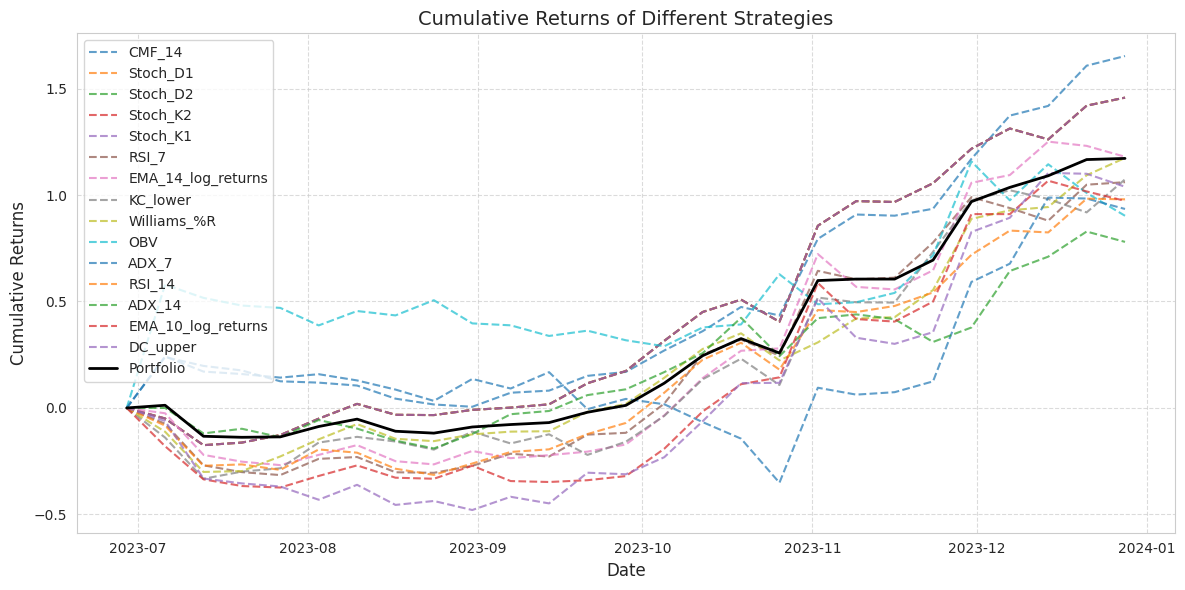

In [91]:
plt.figure(figsize=(12, 6))

for strategy in estimation_returns_adjusted.columns:
    if strategy != 'Portfolio':
        plt.plot(estimation_returns_adjusted.index, estimation_returns_adjusted[strategy].cumsum(), label=strategy, linestyle='--', alpha=0.7)

# Plot the Portfolio
plt.plot(estimation_returns_adjusted.index, estimation_returns_adjusted['Portfolio'].cumsum(), label='Portfolio', linestyle='-', color='black', linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.title("Cumulative Returns of Different Strategies", fontsize=14)
plt.legend(loc='best', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Graph shows strategies and portfolio.

#07 Validation period

The validation period is a designated to evaluate portfolio performance on data which were not used to strategies selection. It helps ensure the portfolio generalizes well.

In [81]:
validation_returns_adjusted = validation_returns.copy()

validation_returns_adjusted['KC_lower'] = validation_returns['KC_lower'] *-1
validation_returns_adjusted['DC_upper'] = validation_returns['DC_upper'] *-1


validation_returns_adjusted['log_returns'] = validation_returns['log_returns'] *-1

Calcualte portfolio

In [94]:
validation_returns_adjusted['Portfolio'] = 0

for strategy in portfolio_strategies:
    validation_returns_adjusted['Portfolio'] += validation_returns_adjusted[strategy]

validation_returns_adjusted['Portfolio'] = validation_returns_adjusted['Portfolio'] / len(portfolio_strategies)

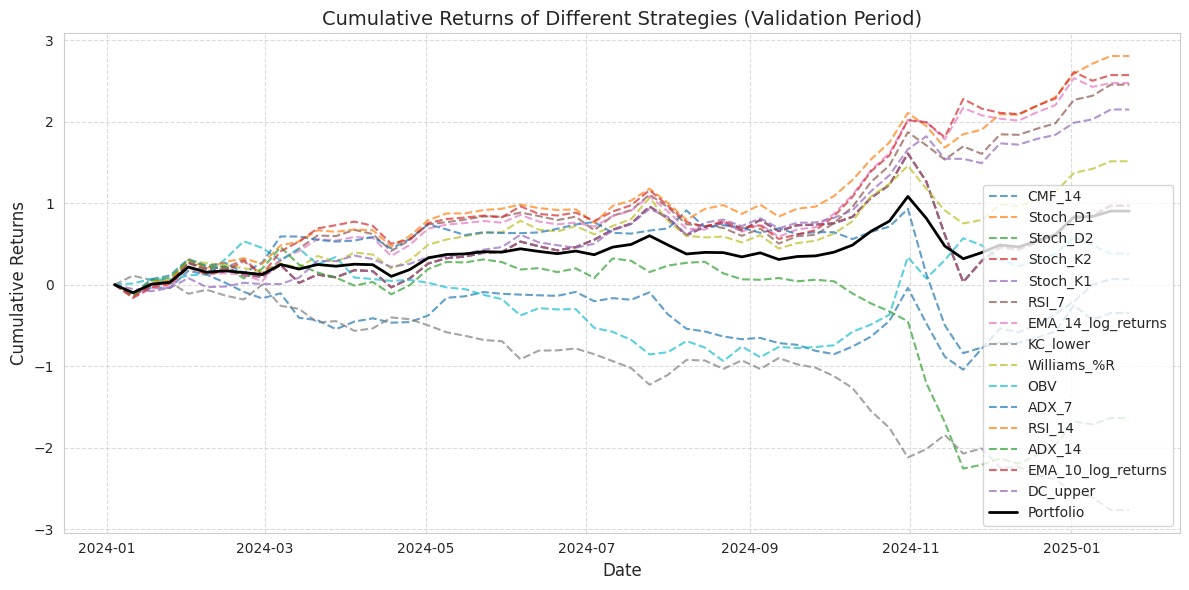

In [96]:
plt.figure(figsize=(12, 6))


for strategy in portfolio_strategies:
    if strategy != 'Portfolio':
        plt.plot(validation_returns_adjusted.index, validation_returns_adjusted[strategy].cumsum(), label=strategy, linestyle='--', alpha=0.7)  # Added alpha for transparency


plt.plot(validation_returns_adjusted.index, validation_returns_adjusted['Portfolio'].cumsum(), label='Portfolio', linestyle='-', color='black', linewidth=2)  # Increased linewidth

plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.title("Cumulative Returns of Different Strategies", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Graph shows that even well performing strategies on estimation period may not be well performing on validation period. Some of strategies are performing better than others. There was a sudden shift in consistency November. As aresult, even strategies which were profitating went down.

In [85]:
stats_validate_adjusted = Calculate_stats_from_log_returns_FCE(validation_returns_adjusted)
stats_validate_adjusted

,Strategy,Annual Return (%),Cumulative Return (%),Annual Volatility (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%)
0,log_returns,-250.901760,-270.201895,126.837089,-1.993910,-2.534818,305.371037
1,log_volume_returns,153.241508,165.029316,104.432765,1.448219,2.555537,71.817107
2,EMA_5_log_returns,280.973033,302.586344,116.533525,2.393929,5.439361,83.372401
3,EMA_10_log_returns,238.743243,257.108108,110.085933,2.150531,4.979395,59.861029
4,EMA_14_log_returns,229.712403,247.382588,105.463516,2.159158,4.337005,50.023451
5,EMA_5_log_volume_returns,248.085595,267.169102,105.613068,2.330068,5.011017,72.024274
6,EMA_10_log_volume_returns,221.170309,238.183410,104.287774,2.101592,4.693406,49.144214
7,EMA_14_log_volume_returns,211.259283,227.509997,104.111252,2.009958,4.195363,44.852676
8,RSI_14,260.476132,280.512758,97.245092,2.657986,4.496589,42.469884
9,RSI_7,227.844944,245.371478,101.463200,2.225880,4.253793,60.066547


The portfolio shows a solid return of 83.82% annually with a relatively low drawdown of 76.39%. Strategies like EMA and RSI deliver strong returns, but with varying levels of risk, while volatility-based strategies like ATR and ADX show significant losses and larger drawdowns.

-----------------------------------------------------

#08 Summary

The project evaluates trading strategies using technical indicators like EMA, RSI, and ATR, focusing on metrics such as return, volatility, and drawdown. The portfolio shows strong returns with relatively low risk, while strategies like EMA and RSI perform well, and volatility-based strategies like ATR and ADX show large drawdowns. The analysis emphasizes the balance between risk and return.